In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio


from matplotlib.pyplot import imread
import h5py
import cv2

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files   

In [5]:
## Load Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [6]:
files = load_data("../input/mydata/BrainTumorData/", ".mat")

directory path:  ../input/mydata/BrainTumorData/
directories:  ['../input/mydata/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/mydata/BrainTumorData/2912.mat
Files Read:  3064


In [7]:
images_h5 = files[:1000]

In [8]:
image_arr = []
image_arr = np.array([np.array(img_h5['cjdata']['image'][()].astype(np.uint32), dtype='object') for img_h5 in images_h5], dtype='object')

In [9]:
# checking for invalid shape images

for idx, img in enumerate(image_arr):
    if img.shape != (512,512):
        print(idx, img.shape)

154 (256, 256)
479 (256, 256)
510 (256, 256)
806 (256, 256)
847 (256, 256)
852 (256, 256)


In [10]:
new_image_arr = []
for img in image_arr:
    if img.shape == (512,512):
        new_image_arr.append(img)

In [11]:
def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(np.asarray(img_arr[i], dtype=float).squeeze(), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

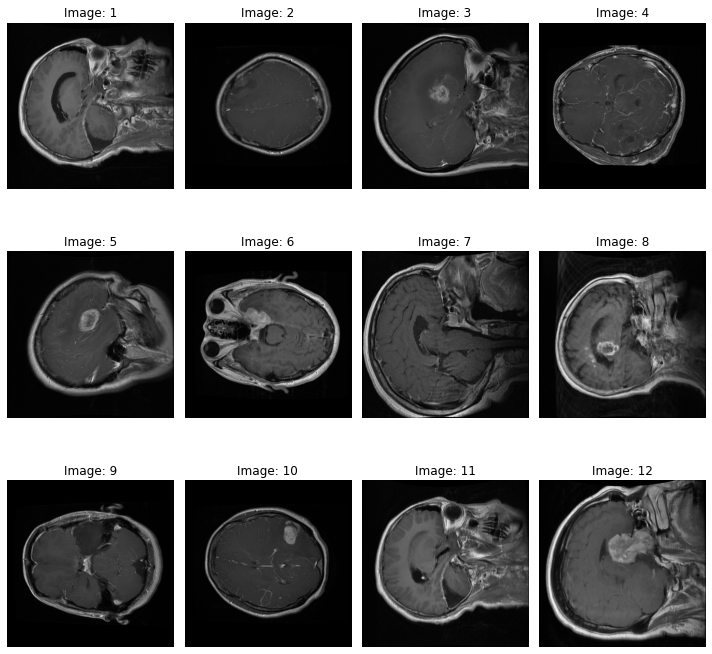

In [12]:
displayImages(new_image_arr)

In [13]:
brain_images = []
for i in range(len(new_image_arr)):
    img = cv2.normalize(np.float32(new_image_arr[i]), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    brain_images.append(img.astype(np.uint32))

## Otsu's method for Optimal Thresholding

### Thresholding is used to create a binary image from a grayscale image

In [14]:
from skimage.filters import threshold_otsu

In [15]:
thresh_arr, thresh_brain_images = [], []
for img in brain_images:
    thresh = threshold_otsu(img)
    binary = img > thresh
    thresh_brain_images.append(binary)
    thresh_arr.append(thresh)

In [16]:
def displayThresResults(brain_img, thr_arr, bin_img, dim=(1, 3), figsize=(15, 5)):
    rows = 3
    cols = 4

    for i in range(rows * cols):
        
        fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(brain_img[i], cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[0].axis('off')

        ax[1].hist(brain_img[i].ravel(), bins=256)
        ax[1].set_title(f"Threshold {thr_arr[i]}")
        ax[1].axvline(thr_arr[i], color='r')

        ax[2].imshow(bin_img[i], cmap=plt.cm.gray)
        ax[2].set_title('Thresholded')
        ax[2].axis('off')

        fig.tight_layout() 
        plt.show()

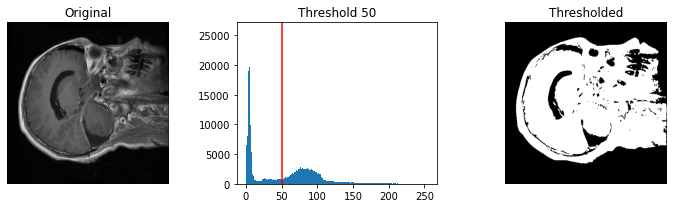

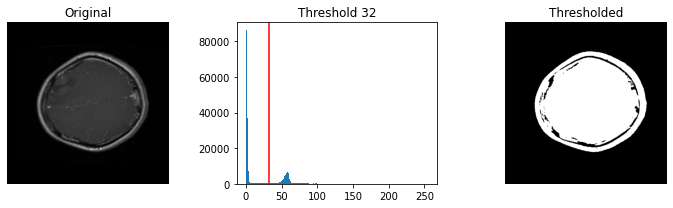

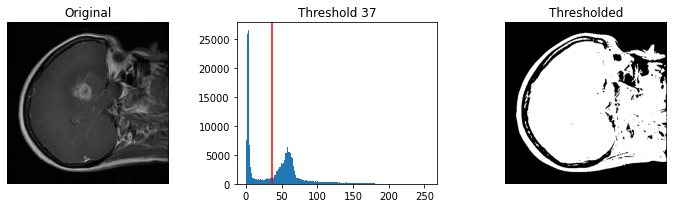

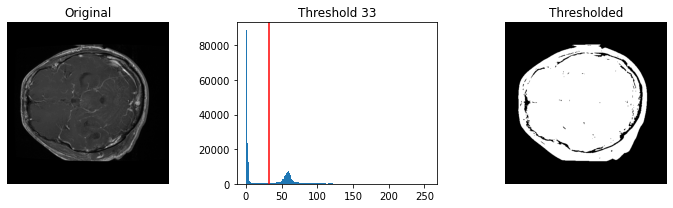

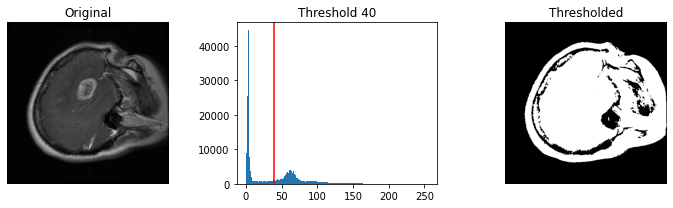

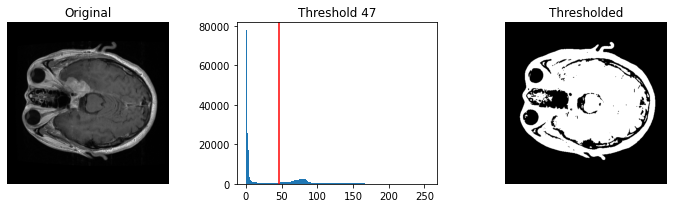

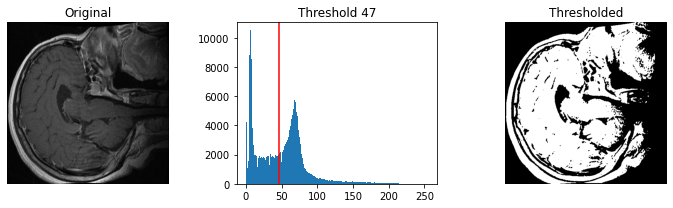

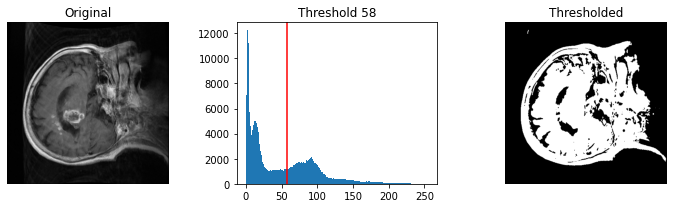

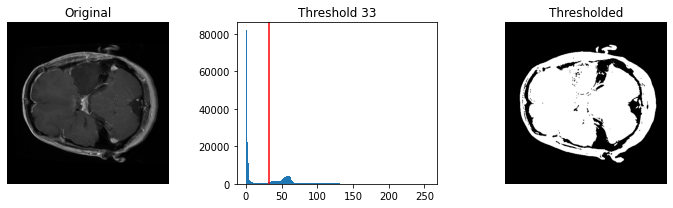

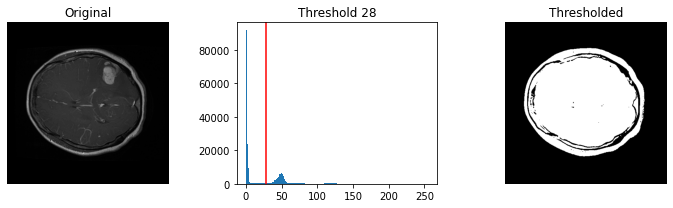

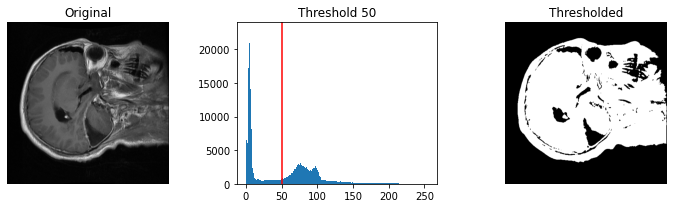

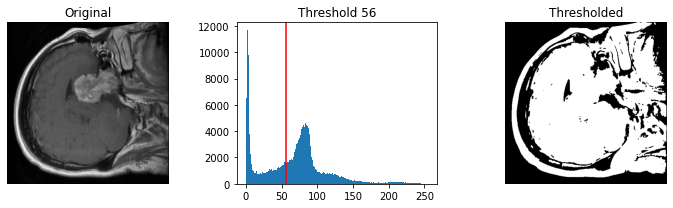

In [17]:
displayThresResults(brain_images, thresh_arr, thresh_brain_images)

In [18]:
tumor_mask = np.array([np.array(img_h5['cjdata']['tumorMask'][()].astype(np.uint32), dtype='object') for img_h5 in images_h5], dtype='object')

In [19]:
# checking for invalid shape images

for idx, img in enumerate(tumor_mask):
    if img.shape != (512,512):
        print(idx, img.shape)

154 (256, 256)
479 (256, 256)
510 (256, 256)
806 (256, 256)
847 (256, 256)
852 (256, 256)


In [20]:
new_tumor_mask = []
for img in tumor_mask:
    if img.shape == (512,512):
        new_tumor_mask.append(img)

In [21]:
masked_images = [img*mask for img, mask in zip(thresh_brain_images, new_tumor_mask)]

In [22]:
final_images = []
for mask_img, brain_img in zip(masked_images, thresh_brain_images):
    final_images.append(brain_img - mask_img)

In [23]:
def displayFinalResults(brain_images, tumor_images, final_images, dim=(1, 3), figsize=(15, 5)):
    rows = 3
    cols = 4
    
    for i in range(rows * cols):
        
        fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(brain_images[i], cmap=plt.cm.gray)
        ax[0].set_title('Brain Image after Applying Thresholding')
        ax[0].axis('off')

        ax[1].imshow(np.array(tumor_images[i], dtype='float').squeeze(), cmap=plt.cm.gray)
        ax[1].set_title('Tumor Mask')
        ax[1].axis('off')

        ax[2].imshow(np.array(final_images[i], dtype='float'), cmap=plt.cm.gray)
        ax[2].set_title('Final Image After Removing Mask')
        ax[2].axis('off')

        fig.tight_layout() 
        plt.show()

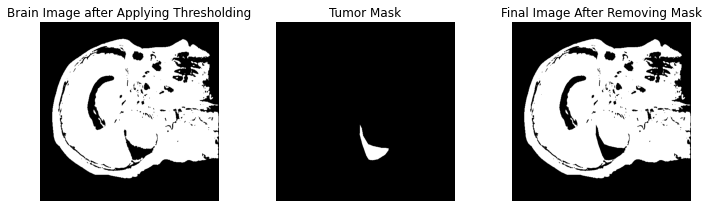

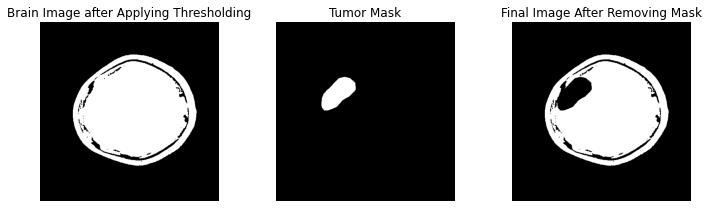

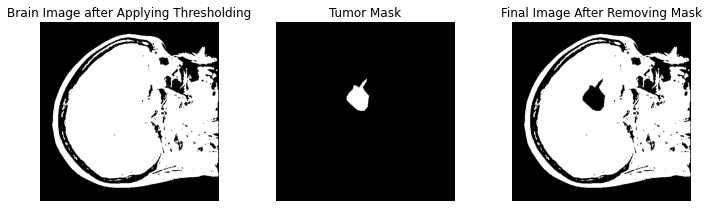

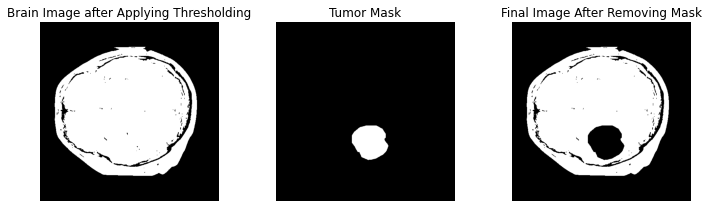

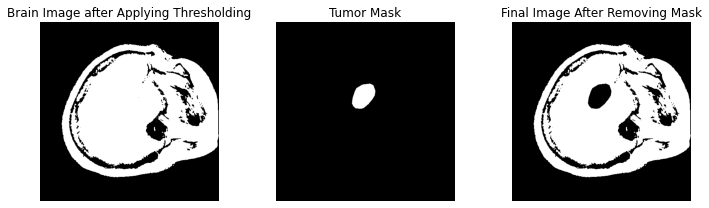

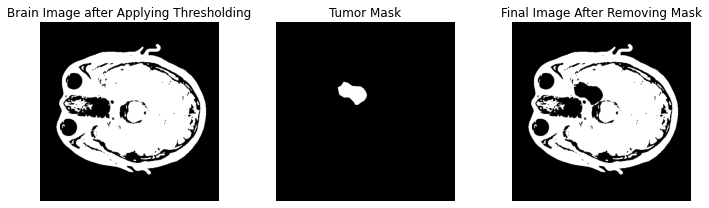

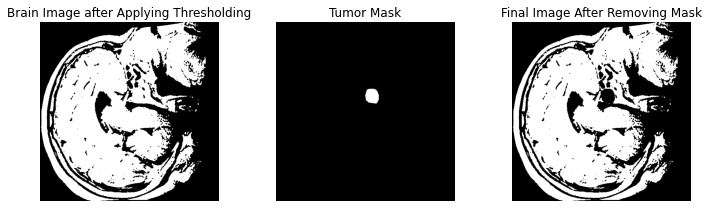

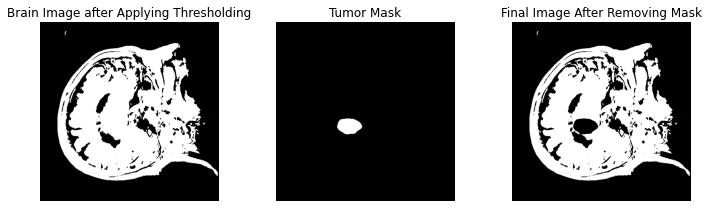

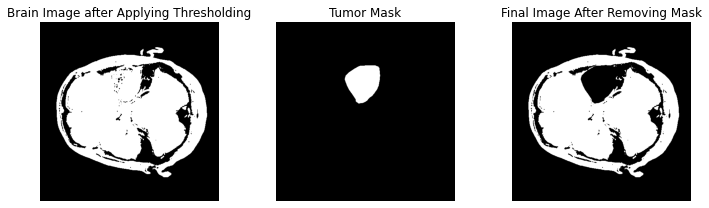

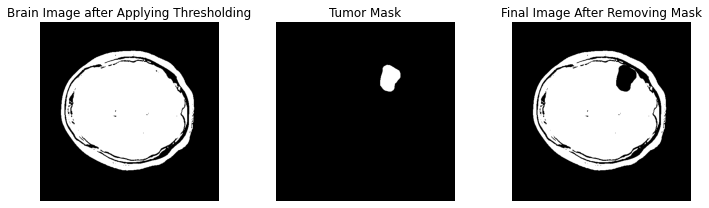

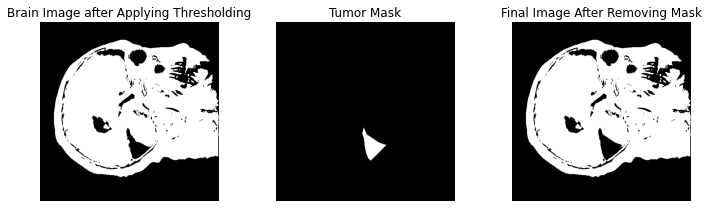

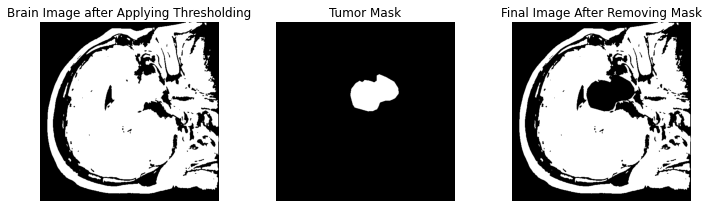

In [24]:
displayFinalResults(thresh_brain_images, new_tumor_mask, final_images)